In [2]:
import numpy as np
from scipy.linalg import lstsq
from scipy.special import hankel1, y0, jv
import matplotlib.pyplot as plt

In [4]:
# Constants
R = 1.4    # radius of source point circle
N = 120    # number of source points
M = 120    # number of boundary points
k = 8      # wavenumber

# Solution to approximate
rho = 1.2
@np.vectorize
def v(z):
  return -1 / 4 * y0(k * np.abs(z - rho))

In [ ]:
# Source points
theta_j = np.linspace(0, 2 * np.pi, N, endpoint=False)
y = R * np.exp(1j * theta_j)

# Boundary points
theta_i = np.linspace(0, 2 * np.pi, M, endpoint=False)
x = np.exp(1j * theta_i)

# Form matrix A
r = np.abs(x[:, None] - y)
A = hankel1(0, k * r)

# Solve least-squares problem for alpha
alpha, _, _, _ = lstsq(A, v(x))

In [ ]:
# Create evaluation grid
grid = np.linspace(-R, R, 100)
X, Y = np.meshgrid(grid, grid)
Z = X + 1j * Y

# Caompute u^(N)
u_N = (alpha * hankel1(0, k * np.abs(Z[:, :, None] - y))).sum(axis=2)

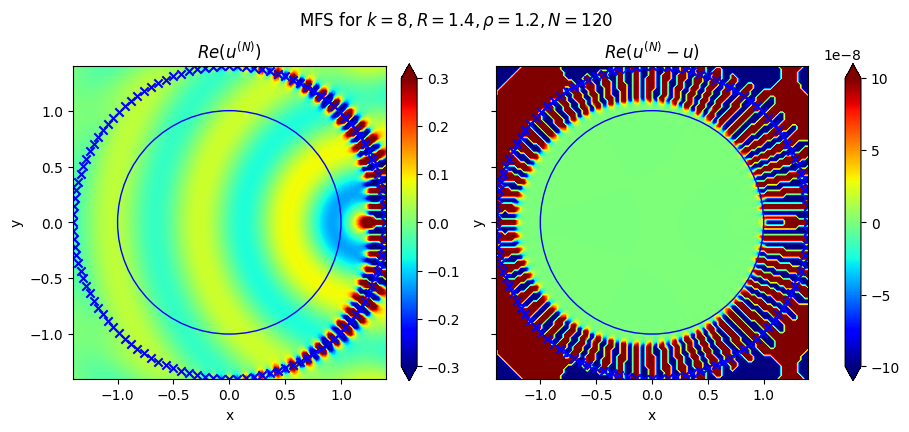

In [ ]:
# Prepare subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,
                               figsize=(9, 4.2), layout="constrained")
fig.suptitle(f"MFS for $k={k}, R={R}, \\rho={rho}, N={N}$")
ax1.set_aspect(1)
ax2.set_aspect(1)
opts = {"levels": 400, "cmap": "jet", "extend": "both"}

# Plot MFS approximation
vmin, vmax = -1e-7, 1e-7
smin, smax = -0.3, 0.3
contour = ax1.contourf(X, Y, np.real(u_N).clip(smin, smax), **opts)
fig.colorbar(contour, ticks=np.linspace(smin, smax, 7))
ax1.add_patch(plt.Circle((0, 0), 1, color='blue', fill=False))
ax1.scatter(np.real(y), np.imag(y), color='blue', marker='x')
ax1.set_title("$Re(u^{(N)})$")
ax1.set_xlabel("x"), ax1.set_ylabel("y")

# Plot error from exact solution
contour = ax2.contourf(X, Y, np.real(u_N - v(Z)).clip(vmin, vmax), **opts)
fig.colorbar(contour, ticks=np.linspace(vmin, vmax, 5))
ax2.add_patch(plt.Circle((0, 0), 1, color='blue', fill=False))
ax2.scatter(np.real(y), np.imag(y), color='blue', marker='x')
ax2.set_title("$Re(u^{(N)} - u)$")
ax2.set_xlabel("x"), ax2.set_ylabel("y")

fig.show()

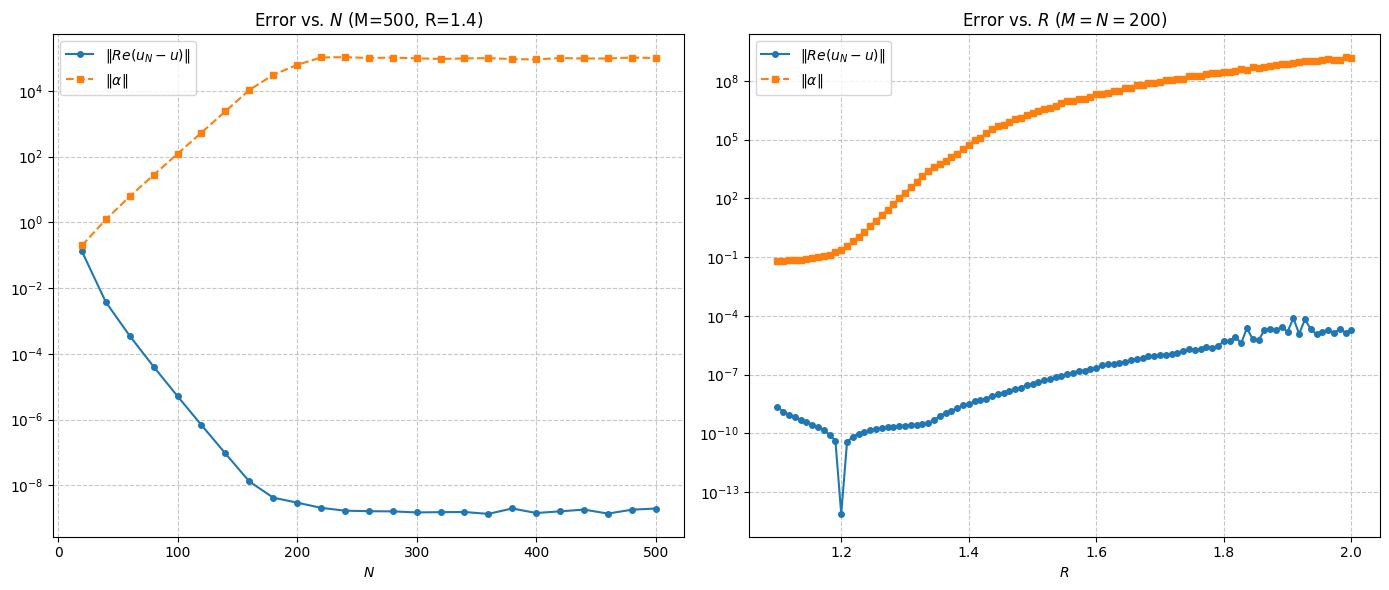

In [5]:
def mfs(M, N, R):
    # Source points
    theta_j = np.linspace(0, 2 * np.pi, N, endpoint=False)
    y = R * np.exp(1j * theta_j)

    # Boundary points
    theta_i = np.linspace(0, 2 * np.pi, M, endpoint=False)
    x = np.exp(1j * theta_i)

    # Assemble the MFS matrix and solve
    A = hankel1(0, k * np.abs(x[:, None] - y))
    alpha, _, _, _ = lstsq(A, v(x))

    # Evaluate the MFS approximation on a finer set of boundary points
    theta_fine = np.linspace(0, 2 * np.pi, 500, endpoint=False)
    x_fine = np.exp(1j * theta_fine)
    u_approx = (alpha * hankel1(0, k * np.abs(x_fine[:, None] - y))).sum(axis=1)
    u_exact_fine = v(x_fine)

    # Compute the absolute error of the real part on the boundary
    err = np.linalg.norm(np.real(u_approx - u_exact_fine))
    return err, np.linalg.norm(alpha)

# Variation with respect to N for fixed R, M
R_fixed = 1.4
N_vals = np.arange(20, 501, 20)
M_fixed = np.max(N_vals)
err_N, alpha_N = [], []
for N in N_vals:
    err, a_norm = mfs(M_fixed, N, R_fixed)
    err_N.append(err)
    alpha_N.append(a_norm)

# Variation with respect to R, with a fixed default M=N=200
N_default = 200
R_vals = np.linspace(1.1, 2.0, 100)
err_R, alpha_R = [], []
for R_val in R_vals:
    err, a_norm = mfs(N_default, N_default, R_val)
    err_R.append(err)
    alpha_R.append(a_norm)

# Prepare subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Variation with N
ax1.semilogy(N_vals, err_N, 'o-', markersize=4, label=r"$\|Re(u_N-u)\|$")
ax1.semilogy(N_vals, alpha_N, 's--', markersize=4, label=r"$\|\alpha\|$")
ax1.set_xlabel(r"$N$")
ax1.set_title(r"Error vs. $N$ (M=500, R=1.4)")
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.7)

# Right plot: Variation with R
ax2.semilogy(R_vals, err_R, 'o-', markersize=4, label=r"$\|Re(u_N-u)\|$")
ax2.semilogy(R_vals, alpha_R, 's--', markersize=4, label=r"$\|\alpha\|$")
ax2.set_xlabel(r"$R$")
ax2.set_title(r"Error vs. $R$ ($M=N=200$)")
ax2.legend()
ax2.grid(True, which="both", ls="--", alpha=0.7)

plt.tight_layout()
plt.show()